# Keras Tutorial #01
# Simple Linear Model with Keras

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/) ported to Keras by Daniel Kornhauser
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

This tutorial was ported to Keras from Tensorflow Tutorial #01.
This tutorial demonstrates the basic workflow of using Keras with a simple linear model. After loading the so-called MNIST data-set with images of hand-written digits, we define and optimize a simple mathematical model in Keras. The results are then plotted and discussed.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. It also helps if you have a basic understanding of Machine Learning and classification.

## Imports

In [1]:
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras import backend as K
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


This was developed using Python 3.5.2 (Anaconda) and Keras version:

In [2]:
keras.__version__

'1.2.2'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
(train_images, train_labels_cls), (test_images, test_labels_cls) = mnist.load_data()
(train_images.shape, train_labels_cls.shape), (test_images.shape, test_labels_cls.shape) 

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

The MNIST data-set has now been loaded and consists of 70.000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels_cls)))
print("- Test-set:\t\t{}".format(len(test_labels_cls)))

Size of:
- Training-set:		60000
- Test-set:		10000


### One-Hot Encoding

When we loaded the data we named it `test_labels_cls` given their classes was represented by a single number . We need the classes as single numbers for various comparisons and performance measures but we need to convert the data-set into One-Hot encoding in order to feed it to our output layer. This means we want to convert the labels from a single number to a vector whose length equals the number of possible classes. We want all elements of the vector to be zero except for the $i$'th element which is one and means the class is $i$. For example, the single number first five images in the test-set are:

In [5]:
test_labels_cls[0:5]

array([7, 2, 1, 0, 4], dtype=uint8)

I order to convert the single number to the One-Hot encoded vectors we can use the ` np_utils.to_categorical` fucntion which converts a vector of integers to binary class matrix.

In [6]:
test_labels = np_utils.to_categorical(test_labels_cls)
train_labels = np_utils.to_categorical(train_labels_cls)
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape) 

(((60000, 28, 28), (60000, 10)), ((10000, 28, 28), (10000, 10)))

We can now see the single numbers for the first five images in the test-set. Compare these to the single number above. For example, the class for the first image is 7, which corresponds to a One-Hot encoded vector where all elements are zero except for the element with index 7.

In [7]:
test_labels[0:5][:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

Note we can also convert the we convert back the One-Hot encoded vectors to a single number by taking the index of the highest element

In [8]:
np.array([label.argmax() for label in test_labels])[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions, shape and range

The data dimensions are used in several places in the source-code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. This means the numbers only have to be changed in one single place. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In order to feed the images to our keras model they must be flatten down from an `img_shape` of 28×28 pixels array to an `img_size_flat` of 784 pixels vector.

In [10]:
train_images = train_images.reshape(train_images.shape[0], img_size_flat)
test_images = test_images.reshape(test_images.shape[0], img_size_flat)

Another data requirment for our keras model is to normalize inputs from 0-255 to 0-1

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The data sets that we will feed to our model end up with the following shapes

In [12]:
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape) 

(((60000, 784), (60000, 10)), ((10000, 784), (10000, 10)))

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

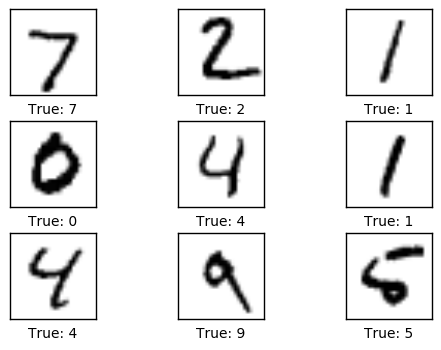

In [14]:
# Get the first images from the test-set.
images = test_images[0:9]

# Get the true classes for those images.
cls_true = test_labels_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Keras

The entire purpose of Keras is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. Keras can be more efficient than NumPy because it can use TensorFlow or Torch which know the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time. In this notebook we will use Keras powered by TensorFlow. 

Keras can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

Keras can use the TensorFlow framework to take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A Keras model consists of the following parts which will be detailed below:

* A model which is essentially just a mathematical function that fits some output given the input variables and the model variables.
* A stack of layers that are going to be fitted so as to make the model perform better.
* A compiled model with: 
    * A loss measure that can be used to guide the optimization of the variables 
    * An optimization method which updates the variables of the model.
    
In addition, the Keras may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

###  Model Selection

There are two types of models available in Keras: the `Sequential` model for simple linear architectures and the `Model` class with functional API for more complex architectures.
In this case let's intance a `Sequential` Model where we can linearly add a stack of layer.

In [15]:
model = Sequential()

#### Adding Layers

Then we 'add' a fully connected layers defined by the `Dense` class in Keras.
In a `Sequential` model, we need to only define the input dimension for the first layer. The flattened image size we feed to the first layer is declared with `input_dim=img_size_flat` given that each image is a vector of length `img_size_flat`. 

In [31]:
model.add(Dense(num_classes, input_dim=img_size_flat))

A `Dense` layer ...

Next, we define a second layer which specify the activation function using the activation argument `activation='softmax'`.
The softmax is necesary given that without it the output of the last layer would be difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the  matrix sums to one, and each element is limited between zero and one.

In [33]:
model.add(Activation('softmax'))

To make the model better at classifying the input images, we must somehow optimize the model weights. To do this we first need to know how well the model currently performs by comparing the predicted output of the model  to the desired output.

###  Selection of loss, optimizer and performance measures

##### Loss

The `'categorical_crossentropy'` is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

##### Optimizer

Now that we have a loss that must be minimized, we can then create an optimizer. In this case it is the basic form of stocastic gradient descent where the step-size is set to 0.5. We instance it with by calling `SGD(lr=0.5)`

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the model for later execution.

In [18]:
sgd = SGD(lr=0.5)

##### Performance measures

We need a few more performance measures to display the progress to the user
We can ask the model to calculate classification accuracy by setting as a metric with `metrics=['accuracy']`

###  Compile Model

Finally, we compile the model, indicating the `loss` function as `'categorical_crossentropy'`  to be optimized with scalar gradient descent `SGD`

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


We can  calculate the cross-entropy for each of the image classifications so we can measure of how well the model performs on each image individually. The `categorical_crossentropy` will guide the optimization of the model's variables by simply taking the average of the cross-entropy for all the image classifications which will be a single scalar value.

### Helper-functions to show performance

Function for printing the classification accuracy on the test-set.

In [40]:
def print_accuracy():
    # Use Keras to compute the accuracy.
    acc = model.evaluate(test_images, test_labels)
    
    # Print the accuracy.
    print("\nAccuracy on test-set:: %.2f%%" % (acc[1]*100))

Function for printing and plotting the confusion matrix using scikit-learn.

In [24]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = test_labels_cls
    
    # Get the predicted classifications for the test-set.
    pred = model.predict(test_images)
    cls_pred = np.array([label.argmax() for label in pred])
    
    print((cls_true.shape, cls_pred.shape))
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    #test_labels_cls, cls_pred

    
    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Function for plotting examples of images from the test-set that have been mis-classified.

In [26]:
def plot_example_errors():
    # Use Keras to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.

    # Get the predicted classifications for the test-set.
    # We are using a sigmoid activation function on the output layer, 
    # so the predictions will be in the range between 0 and 1. 
    pred_sigmoid = model.predict(test_images)
    
    # Let's round the decimal number prediction to obtain a 1 hot representation
    pred_one_hot = [np.round(x) for x in pred_sigmoid]
    
    # Lets convert the one-hot representation to single numbers
    cls_pred = np.array([label.argmax() for label in pred_one_hot])

    # Get the correct classifications for the test-set.
    correct = cls_pred == test_labels_cls

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_images[incorrect]

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_labels_cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    

Now let's create a function for plotting the `weights` of the model. 10 images are plotted, one for each digit that the model is trained to recognize.

In [29]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = model.get_weights()[0]
    print(w.shape)
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [63]:
print_accuracy()

 9632/10000 [===========================>..] - ETA: 0s
Accuracy on test-set:: 90.90%


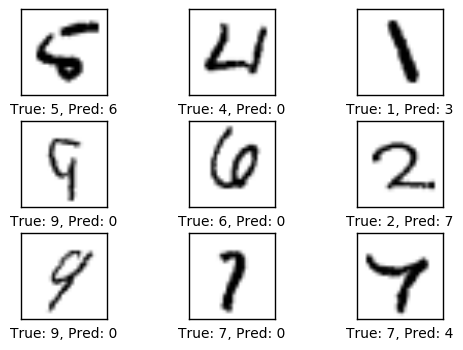

In [64]:
plot_example_errors()

### Fitting with Keras

`model.fit` perfoms a number of optimization iterations so as to gradually improve the model. At each iteration, a new batch of data is selected from the training-set and then Keras executes the optimizer using those training samples.

**`x` and `y`**

We must  pass our training images as `x` with `x=data.train.images`, and then we pass our labels providing the ground truth as `y` with `y=data.train.labels` in order to train the model.

** `batch size` **

There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of 100 images set with `batch_size = 100` at each iteration of the optimizer.

`model.fit` performs a number of optimization iterations so as to gradually improve the weights of the model found in `model.weights`. At each iteration, a new batch of data is selected from the training-set and then keras executes the optimizer using those training samples.

** `validation_data` **

Optionally can pass the validation data with `validation_data=(data.test.images, data.test.labels)`. The validation data is used by the optimizer to estimate how well your model has been trained in order to change the `model.weights`. Keras would automaticlly split 'x' and 'y' into training and test datasets if validation_data is ommited.

** `nb_epoch=10` **

We also have to provide how many iteration we want to optimize with `nb_epoch=10`

## Performance after 1 optimization iteration

Already after a single optimization iteration, the model has increased its accuracy on the test-set to 40.7% up from 9.8%. This means that it mis-classifies the images about 6 out of 10 times, as demonstrated on a few examples below.

In [65]:
# Fit the model
model.fit(x=train_images,  y=train_labels, nb_epoch=1, 
          batch_size=200, verbose=1,
          validation_data=(test_images, test_labels) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s - loss: 0.3218 - acc: 0.9085 - val_loss: 0.3001 - val_acc: 0.9165


In [67]:
print_accuracy()

 8576/10000 [========================>.....] - ETA: 0s
Accuracy on test-set:: 91.65%


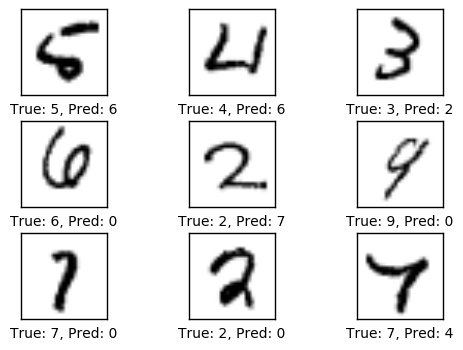

In [68]:
plot_example_errors()

The weights can also be plotted as shown below. Positive weights are red and negative weights are blue. These weights can be intuitively understood as image-filters.

For example, the weights used to determine if an image shows a zero-digit have a positive reaction (red) to an image of a circle, and  have a negative reaction (blue) to images with content in the centre of the circle.

Similarly, the weights used to determine if an image shows a one-digit react positively (red) to a vertical line in the centre of the image, and react negatively (blue) to images with content surrounding that line.

Note that the weights mostly look like the digits they're supposed to recognize. This is because only one optimization iteration has been performed so the weights are only trained on 100 images. After training on several thousand images, the weights become more difficult to interpret because they have to recognize many variations of how digits can be written.

(784, 10)


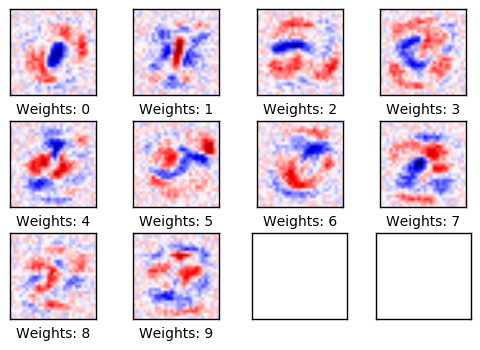

In [69]:
plot_weights()

## Performance after 10 optimization iterations

In [77]:
# We have already performed 1 iteration.
# Since calculating the accuracy on the test step at every step slow us down let's omit:
model.fit(x=train_images,  y=train_labels, nb_epoch=9, 
          batch_size=200, verbose=1 );

Epoch 1/9
60000/60000 [==============================] - 0s - loss: 0.2490 - acc: 0.9311     
Epoch 2/9
60000/60000 [==============================] - 0s - loss: 0.2480 - acc: 0.9318     
Epoch 3/9
60000/60000 [==============================] - 0s - loss: 0.2477 - acc: 0.9315     
Epoch 4/9
60000/60000 [==============================] - 0s - loss: 0.2473 - acc: 0.9318     
Epoch 5/9
60000/60000 [==============================] - 0s - loss: 0.2468 - acc: 0.9320     
Epoch 6/9
60000/60000 [==============================] - 0s - loss: 0.2470 - acc: 0.9319     
Epoch 7/9
60000/60000 [==============================] - 0s - loss: 0.2465 - acc: 0.9321     
Epoch 8/9
60000/60000 [==============================] - 0s - loss: 0.2462 - acc: 0.9320     
Epoch 9/9
60000/60000 [==============================] - 0s - loss: 0.2463 - acc: 0.9326     


In [72]:
print_accuracy()

 9920/10000 [============================>.] - ETA: 0s
Accuracy on test-set:: 92.40%


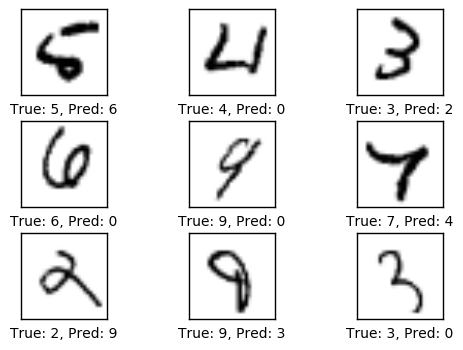

In [73]:
plot_example_errors()

(784, 10)


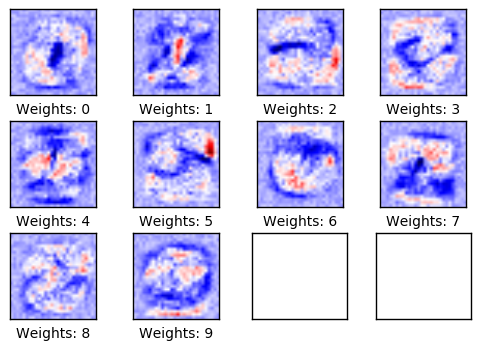

In [74]:
plot_weights()

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model only mis-classifies about one in ten images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while others are quite obvious and should have been classified correctly by a good model. But this simple model cannot reach much better performance and more complex models are therefore needed.

In [ ]:
# We have already performed 1000 iterations.
model.fit(x=train_images,  y=train_labels, nb_epoch=990, 
          batch_size=200, verbose=1 )

In [78]:
print_accuracy()

 8736/10000 [=========================>....] - ETA: 0s
Accuracy on test-set:: 92.46%


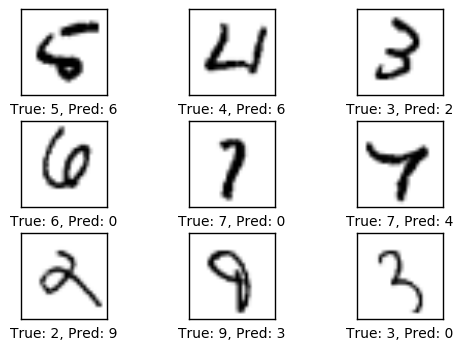

In [79]:
plot_example_errors()

The model has now been trained for 1000 optimization iterations, with each iteration using 100 images from the training-set. Because of the great variety of the images, the weights have now become difficult to interpret and we may doubt whether the model truly understands how digits are composed from lines, or whether the model has just memorized many different variations of pixels.

(784, 10)


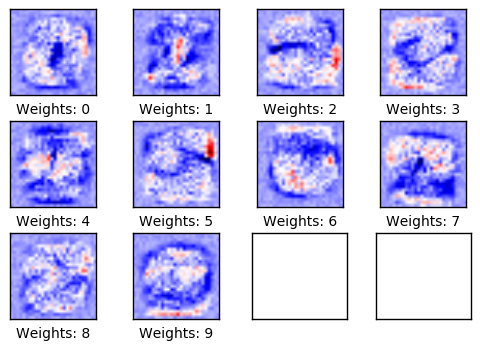

In [80]:
plot_weights()

We can also print and plot the so-called confusion matrix which lets us see more details about the mis-classifications. For example, it shows that images actually depicting a 5 have sometimes been mis-classified as all other possible digits, but mostly either 3, 6 or 8.

[[ 968    0    0    2    0    2    5    1    2    0]
 [   0 1116    2    2    1    2    4    2    6    0]
 [  13   15  885   19   19    3   13   14   45    6]
 [   5    1   12  916    1   36    1   13   17    8]
 [   2    3    2    2  943    0    8    2    7   13]
 [  11    3    1   28   13  788   12    7   25    4]
 [  16    3    3    2   22   24  884    1    3    0]
 [   4   14   18    7   12    1    0  951    2   19]
 [   9   15    5   29   11   40    9   13  839    4]
 [  12    8    1    9   84   11    0   34    6  844]]


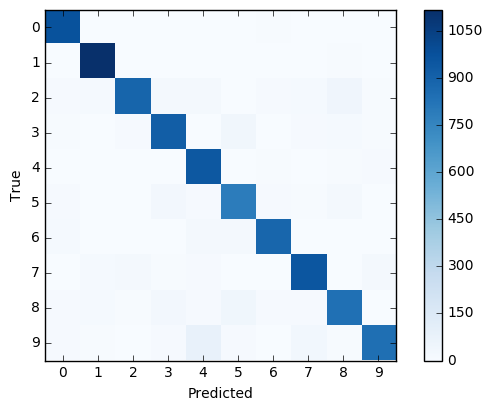

In [47]:
print_confusion_matrix()

### Inside the model step by step 

To make the model better at classifying the input images, we must somehow change the model. To do this we first need to know how well the model currently performs by comparing the predicted output of the model to the desired output.

The goal of fitting the model is therefore to minimize the `'categorical_crossentropy'` so it gets as close to zero as possible by changing the `weights` of `Dense` layer of the model.

The `Dense` layer with no activation function simply multiplies the images pixels ( 768 in this case ) with the layer's weights (768 in this case) and adds the layer's biases. We can get the weight and biases by calling `model.get_weights()` which returns a list with 2 arrays for each `Dense` layer:
* the first array is a matrix of weights "w"
* the second array ia a vector of biases "b" 
The output of the `Dense` layer can be described as:

dense_layer_output = matrix_mulitplication(x, weights) + biases

(It can be confusing that you get the biases from model.get_weights, but it's a decision from the keras team to simplify the API, since you can think of biases as "special" weights you add instead of "normal" weights you multiply.)

Let's look what's inside our model which contains only one Dense Layer and Softmax Activation. The Dense Layer multiplies the images fed through the `x` variable with a matrix of weights and then adds a vector of biases. 
Let's take the first 2 images and feed those image thru the first layer:

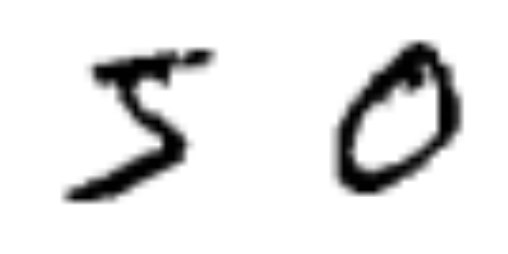

In [59]:
# Take the first 2 numbers
fig, axes = plt.subplots(1,2)
[axe.axis('off') for axe in axes]
axes[0].imshow(train_images[0].reshape(img_shape), cmap='binary')
axes[1].imshow(train_images[1].reshape(img_shape), cmap='binary')
x_2 = [train_images[0:2]]

This simple mathematical model multiplies the images in the placeholder variable `x` with the weights and then adds the biases.

The result of our matrix x0 of shape `[num_images, img_size_flat]` and has shape `[img_size_flat, num_classes]`, so the multiplication of those two matrices result in a matrix with shape `[num_images, num_classes]` and then the biases vector is of length `[num_classes]` is added to each row of that matrix.

Note that the name `logits` is typical TensorFlow terminology, but other people may call the variable something else.

In [60]:
"x", train_images.shape, "weights", model.get_weights()[0].shape, "biases" , model.get_weights()[1].shape

('x', (60000, 784), 'weights', (784, 10), 'biases', (10,))

In [61]:
# Pass them thru the first layer
get_1st_layer_output = K.function([model.layers[0].input], [model.layers[0].output])
logits_2 = get_1st_layer_output(x_2)
logits_2[0]

array([[  0.37562481,  -3.81264114,   0.61146963,   4.38534927,
         -5.26187515,   4.72072649,  -0.84940016,   0.81203783,
         -0.01035923,  -0.83744562],
       [ 10.20207787,  -7.01943207,   0.14902362,   0.68472254,
         -6.2102747 ,   3.03758383,  -0.83153355,  -1.12410522,
         -0.64869684,  -1.92699969]], dtype=float32)

Now `logits` is a matrix with `num_images` rows and `num_classes` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `logits` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [62]:
get_2nd_layer_output = K.function([model.layers[1].input],[model.layers[1].output])
y_pred = get_2nd_layer_output(logits_2)
y_pred[0]

array([[  7.28150457e-03,   1.10479225e-04,   9.21822712e-03,
          4.01441634e-01,   2.59350018e-05,   5.61403215e-01,
          2.13894527e-03,   1.12655666e-02,   4.94983187e-03,
          2.16466840e-03],
       [  9.99057472e-01,   3.31423848e-08,   4.30134896e-05,
          7.34946516e-05,   7.44382120e-08,   7.72841158e-04,
          1.61344433e-05,   1.20418035e-05,   1.93713040e-05,
          5.39509210e-06]], dtype=float32)

The predicted class can be calculated from the `y_pred` matrix by taking the index of the largest element in each row.

In [114]:
y_pred_cls = np.argmax(output_2nd_layer[0][0]), np.argmax(output_2nd_layer[0][1])

(5, 0)

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change the learning-rate for the optimizer.
* Change the optimizer to e.g. `AdagradOptimizer` or `AdamOptimizer`.
* Change the batch-size to e.g. 1 or 1000.
* How do these changes affect the performance?
* Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
* Change the function `plot_example_errors()` so it also prints the `logits` and `y_pred` values for the mis-classified examples.
* Use `sparse_softmax_cross_entropy_with_logits` instead of `softmax_cross_entropy_with_logits`. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.